In [1]:
import torch 
from torch import nn

# Batch Normalization

## Using the pytorch

In [8]:
#? consider you are having 2 batch, 4 feature of spatial information of size 3x3
inputs = torch.arange(2*4*3*3,dtype=torch.float).reshape([2,4,3,3])

In [13]:
torch_outputs = nn.BatchNorm2d(num_features= 4)(inputs)

In [19]:
inputs.mean(dim=0,keepdim=True)

torch.Size([1, 4, 3, 3])

In [15]:
import inspect
inspect.signature(nn.BatchNorm2d)

<Signature (num_features: int, eps: float = 1e-05, momentum: float = 0.1, affine: bool = True, track_running_stats: bool = True, device=None, dtype=None) -> None>

## Building from Scratch

In [43]:
class BatchNorm2dScratch(nn.Module):
    def __init__(self,num_features:int,eps:float=1e-5,momentum:float=0.9) -> None:
        super().__init__()
        self.eps = eps
        self.momentum = momentum
        # this for the convolution
        shape = (1,num_features,1,1)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        #? to track the running mean and running var to use them during the testing ah mean and var
        self.register_buffer("moving_mean",torch.zeros(shape))
        self.register_buffer("moving_var",torch.ones(shape))
        
    def forward(self,x:torch.Tensor):
        if self.moving_mean.device != x.device:
            self.moving_mean.to(x.device)
            self.moving_var.to(x.device)
        
        y,self.moving_mean,self.moving_var = self._batch_norm(self.training,x,self.gamma,self.beta,
                                                              self.moving_mean,self.moving_var,self.eps,
                                                              self.momentum)
        return y
        
    
    
    def _batch_norm(self,is_training,x:torch.Tensor,gamma,beta,moving_mean,moving_var,eps=1e-5,momentum=0.9):
        if not is_training:
            # during the test phase just calculate the x_hat using the running mean
            x_hat = (x - moving_mean)/torch.sqrt(moving_var+eps)
        else:
            mean = x.mean(dim=(0,2,3),keepdim=True)
            var = ((x-mean)**2).mean(dim=(0,2,3),keepdim=True)
            
            x_hat = (x-mean)/(torch.sqrt(var+eps))
            
            moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
            moving_var = (1.0 - momentum) * moving_var + momentum * var
        
        y = gamma * x_hat + beta
        return y,moving_mean.data,moving_var.data
        

In [46]:
scratch_output = BatchNorm2dScratch(num_features=4,momentum=0.1)(inputs)

In [47]:
torch.allclose(torch_outputs,scratch_output)

True

## Some experiment Results

### Comparing the accuracy

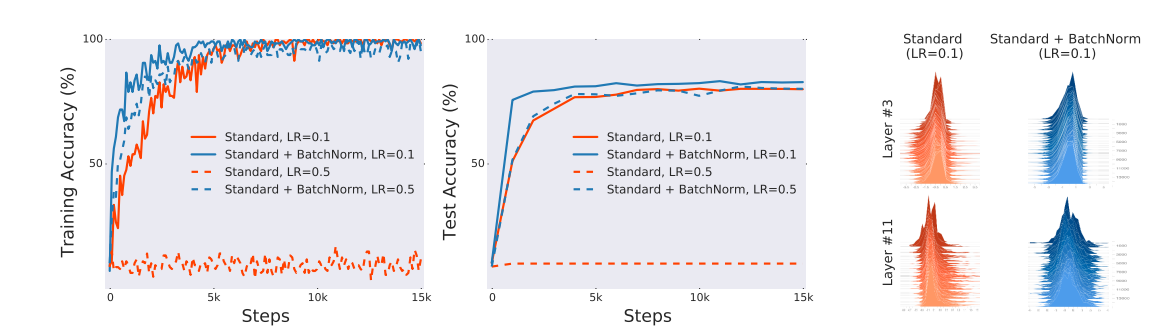


Analyses: 
1. Differences:
    * Figure 1 shows that using BatchNorm during training will enter convergence faster than not using batchnorm
    * Figure 2 shows that using BatchNorm will achieve a higher accuracy rate than not using BatchNorm when testing
2. Similarities:
    * Figure 3 shows that with and without BatchNorm, the difference in feature weight distribution is not significant


### Loss LandScape

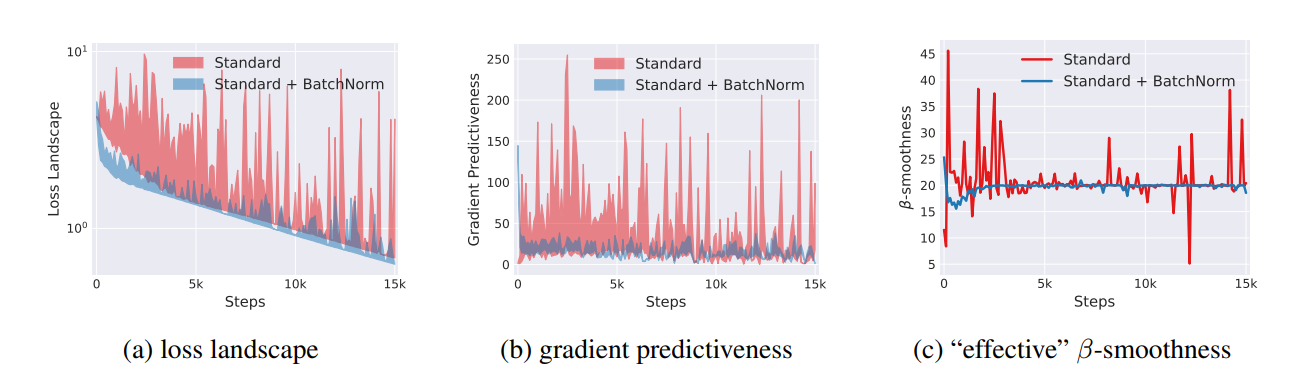

BatchNorm improves the smoothness of loss, making the loss function surface smooth, and the smooth loss function making gradient descent very easy